# Capter 4: Results (part 2)

This chapter presents the main findings, highlighting the most important
research results


In [1]:
import torch
import numpy as np
import glob

from configs._scanners import get_miniPET_geometry
from utils.inits import init_pytorch
from utils.metrics import compute_metrics
from utils.plots import plot_images


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: /opt/conda/envs/smn/lib/libparallelproj_c.so.1.10.0
        parallelproj CUDA lib         ..: /opt/conda/envs/smn/lib/libparallelproj_cuda.so.1.10.0
        parallelproj CUDA kernel file ..: /opt/conda/envs/smn/lib/projector_kernels.cu.1.10.0
        parallelproj CUDA present     ..: True
        parallelproj cupy enabled     ..: True
        


Initialise modules and variables


In [2]:
# Initialize the device
device: torch.device = init_pytorch()

# Set volume dimensions
IMG_WIDTH: int = 147
IMG_HEIGHT: int = 147
IMG_DEPTH: int = 35

Using CUDA with 1 GPU(s)...


In [3]:
from utils.data import (
    load_miniPET_img,
    load_miniPET_sino,
    save_tensor_to_nii,
    create_SLPhantom,
)

In [4]:
APPLY_BLUR: bool = True
NOISE_LEVEL: float = 0.5

## Synthetic Test Data


In [5]:
# Create the miniPET geometry
miniPET_geometry = get_miniPET_geometry(
    device=device, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_rings=IMG_DEPTH
)

In [6]:
sinogram_slp, image_slp = create_SLPhantom(
    device, IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, miniPET_geometry.proj, NOISE_LEVEL
)

## Pre-clinical Test Dat


In [7]:
SLICE_TO_PLOT: int = 17

In [8]:
# MiniPET reconstruction file path
FILE_IMG_PATH: str = "data/GT.mnc"
# MiniPET sinogram file path
FILE_SINO_PATH: str = "data/sino40min.sino.mnc"

In [9]:
# Load the miniPET slices and sinogram
sinogram_mouse = load_miniPET_sino(device, FILE_SINO_PATH)
image_mouse = load_miniPET_img(device, FILE_IMG_PATH)

In [10]:
slp_slice: torch.Tensor = image_slp[:, SLICE_TO_PLOT, :]

mouse_slice: torch.Tensor = image_mouse[:, SLICE_TO_PLOT, :]

## Reconstruction

The architectures described previously were trained using the mixed dataset and the MSE+Dice score loss function.


In [11]:
from algoritms.iterative import OSEM
from utils.evaluate import evaluate_model
from utils.plots import plot_iterations_output, plot_iterations_output_3d

In [12]:
import torch
from parallelproj import RegularPolygonPETProjector


def process_model_diff_noise(
    device: torch.device,
    model: torch.nn.Module,
    weights_path: str,
    img_size: tuple,
    projector: RegularPolygonPETProjector,
) -> list:
    """Loads a model weights and evaluates it on given sinograms.

    Args:
        device (torch.device): The device to use.
        model (torch.nn.Module): The model to be used for evaluation.
        weights_path (str): Path to the pre-trained model weights file.
        img_size (tuple): The size of the image.
        projector (RegularPolygonPETProjector): The projector.

    Returns:
        list: A list containing lists of the computed metrics.
    """
    noise_levels = np.arange(0.5, 10.0, 0.5).tolist()

    IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH = img_size

    mse_noise_mean = []
    mse_noise_std = []
    ssim_noise_mean = []
    ssim_noise_std = []
    psnr_noise_mean = []
    psnr_noise_std = []

    for noise_level in noise_levels:
        mse_list = []
        ssim_list = []
        psnr_list = []

        for file_name in sorted(glob.glob(weights_path), reverse=True):

            # Load the model weights
            model.load_state_dict(torch.load(file_name, weights_only=True))

            sinogram_slp, image_slp = create_SLPhantom(
                device, IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, projector, noise_level
            )

            # Evaluate the model on the SLP sinogram
            logan: torch.Tensor = evaluate_model(
                device,
                model,
                sinogram_slp.unsqueeze(0),
            )

            metrics = compute_metrics(device, image_slp, logan)
            mse_list.append(metrics["mse"].item())
            ssim_list.append(metrics["ssim"].item())
            psnr_list.append(metrics["psnr"].item())

        mse_noise_mean.append(np.mean(mse_list))
        mse_noise_std.append(np.std(mse_list))
        ssim_noise_mean.append(np.mean(ssim_list))
        ssim_noise_std.append(np.std(ssim_list))
        psnr_noise_mean.append(np.mean(psnr_list))
        psnr_noise_std.append(np.std(psnr_list))

    return [
        (mse_noise_mean, mse_noise_std),
        (ssim_noise_mean, ssim_noise_std),
        (psnr_noise_mean, psnr_noise_std),
    ]

### OSEM


In [13]:
MLEM_ITERATIONS: int = 18
OSEM_SUBSETS: int = 2
OSEM_ITERATIONS: int = MLEM_ITERATIONS // OSEM_SUBSETS

In [14]:
# Initialise and run the OSEM algorithm
osem = OSEM(
    projector=miniPET_geometry.proj,
    device=device,
    n_iterations=OSEM_ITERATIONS,
    n_subsets=OSEM_SUBSETS,
)

mse_list = []
ssim_list = []
psnr_list = []
for _ in range(3):

    Osem_logan: torch.Tensor = osem(sinogram=sinogram_slp)
    Osem_logan_slice: torch.Tensor = Osem_logan[:, SLICE_TO_PLOT, :]

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Osem_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Osem_mouse: torch.Tensor = osem(sinogram=sinogram_mouse)
Osem_mouse_slice: torch.Tensor = Osem_mouse[:, SLICE_TO_PLOT, :]

OSEM algorithm finished.
Execution time: 0.1176 seconds
OSEM algorithm finished.
Execution time: 0.1099 seconds
OSEM algorithm finished.
Execution time: 0.1094 seconds
MSE=1.37e-02 +/- 8.78e-10	SSIM=0.64 +/- 0.00e+00	PSNR=18.63 +/- 0.00e+00
OSEM algorithm finished.
Execution time: 0.1250 seconds


### LPD-based Models


In [15]:
from configs import _models

from models.functions.embeddings import sinogram_patching

In [16]:
def process_model(
    device: torch.device,
    model: torch.nn.Module,
    weights_path: str,
    sinogram_slp: torch.Tensor,
    sinogram_mouse: torch.Tensor,
    slice_to_plot: int,
) -> tuple:
    """Loads a model weights and evaluates it on given sinograms.

    Args:
        device (torch.device): The device to use.
        model (torch.nn.Module): The model to be used for evaluation.
        weights_path (str): Path to the pre-trained model weights file.
        sinogram_slp (torch.Tensor): Input sinogram for the SLP dataset (single 2D sinogram).
        sinogram_mouse (torch.Tensor): Input sinogram for the mouse dataset (single 2D sinogram).
        slice_to_plot (int): Index of the slice to extract from the 3D output tensor.

    Returns:
        tuple: A tuple containing:
            - logan (torch.Tensor): The model's output for the SLP sinogram.
            - logan_slice (torch.Tensor): The extracted slice from the SLP output tensor.
            - mouse (torch.Tensor): The model's output for the mouse sinogram.
            - mouse_slice (torch.Tensor): The extracted slice from the mouse output tensor.
    """
    # Load the model weights
    model.load_state_dict(torch.load(weights_path, weights_only=True))

    # Evaluate the model on the SLP sinogram
    logan: torch.Tensor = evaluate_model(
        device,
        model,
        sinogram_slp.unsqueeze(0),
    )

    # Extract the specified slice from the SLP output
    logan_slice: torch.Tensor = logan[:, slice_to_plot, :]

    # Evaluate the model on the mouse sinogram
    mouse: torch.Tensor = evaluate_model(
        device,
        model,
        sinogram_mouse.unsqueeze(0),
    )

    name = weights_path.split("/")[1]

    save_tensor_to_nii(mouse, f"outputs/{name}/mouse.nii")

    # Extract the specified slice from the mouse output
    mouse_slice: torch.Tensor = mouse[:, slice_to_plot, :]

    # Return the full outputs and the specified slices
    return logan, logan_slice, mouse, mouse_slice

In [17]:
# Create the miniPET geometry
miniPET_geometry_patch = get_miniPET_geometry(
    device=device,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    num_rings=1,
    distance_between_rings=0,
)
# Get the indices for positional tokenisation
indices = sinogram_patching(
    device=device,
    projector=miniPET_geometry_patch.proj,
    patch_size=7,
)

In [18]:
NUM_LPD_ITERATIONS: int = 3

_U-Net LPD_


In [19]:
CONFIG_NAME_1: str = "lpdUnet2D_3"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_1}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    # Initialise the full model
    model = _models.get_LPD_Unet2D_model(
        device,
        projector=miniPET_geometry.proj,
        n_iter=NUM_LPD_ITERATIONS,
    )

    # Move the model to the device
    model = model.to(device)

    (
        Unet2D_logan,
        Unet2D_logan_slice,
        Unet2D_mouse,
        Unet2D_mouse_slice,
    ) = process_model(
        device, model, file_name, sinogram_slp, sinogram_mouse, SLICE_TO_PLOT
    )

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet2D_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.5347 seconds
Execution time: 0.0894 seconds
Execution time: 0.0873 seconds
Execution time: 0.0904 seconds
Execution time: 0.0856 seconds
Execution time: 0.0916 seconds
MSE=8.44e-03 +/- 2.04e-04	SSIM=0.91 +/- 3.22e-03	PSNR=20.74 +/- 1.05e-01


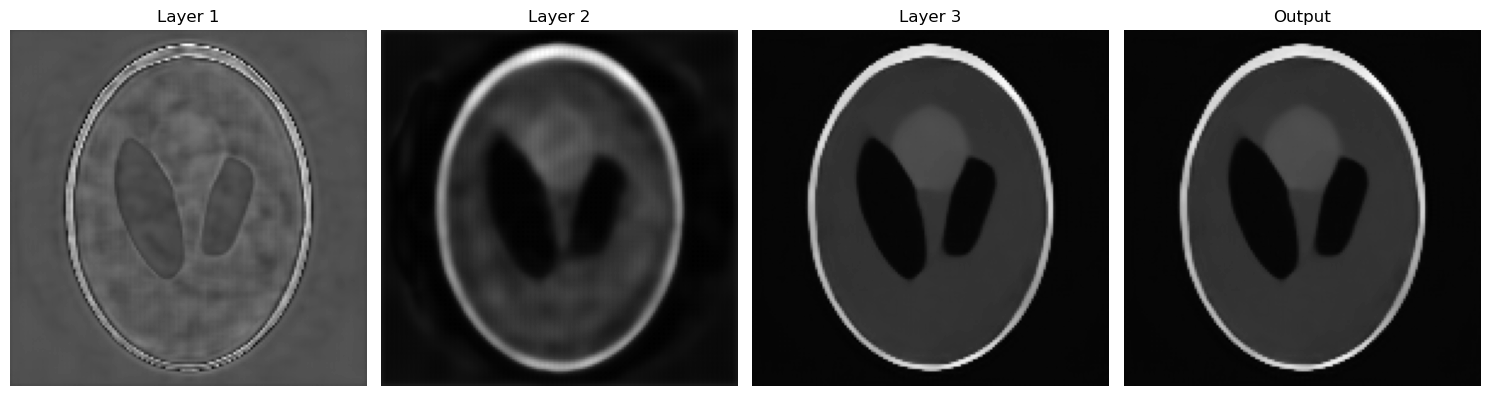

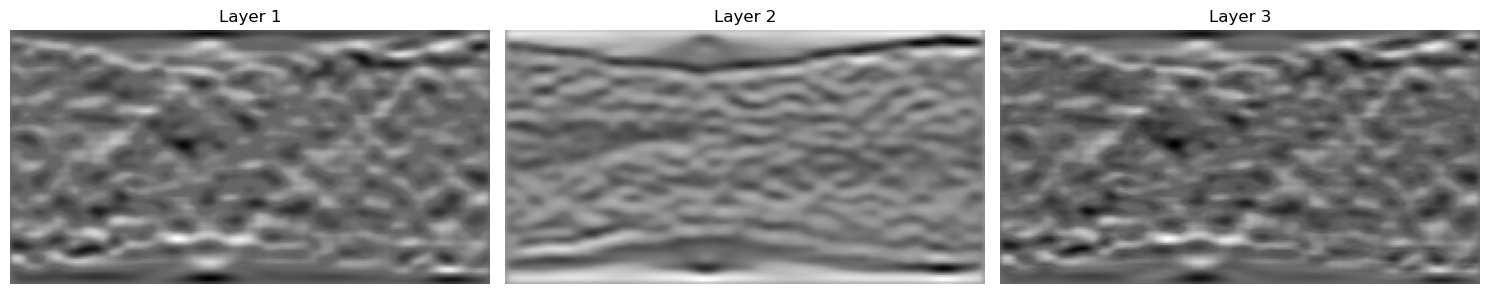

In [20]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False
)
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True
)

In [21]:
CONFIG_NAME_1: str = "lpdUnet2D_3"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_1}/*_weights.pt"

Unet2D_metrics = process_model_diff_noise(
    device,
    model,
    WEIGHTS_PATH,
    (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    miniPET_geometry.proj,
)

Execution time: 0.0881 seconds
Execution time: 0.0875 seconds
Execution time: 0.0877 seconds
Execution time: 0.0880 seconds
Execution time: 0.0869 seconds
Execution time: 0.0874 seconds
Execution time: 0.0872 seconds
Execution time: 0.0874 seconds
Execution time: 0.0873 seconds
Execution time: 0.0866 seconds
Execution time: 0.0868 seconds
Execution time: 0.0874 seconds
Execution time: 0.0870 seconds
Execution time: 0.0865 seconds
Execution time: 0.0876 seconds
Execution time: 0.0868 seconds
Execution time: 0.0897 seconds
Execution time: 0.0873 seconds
Execution time: 0.0868 seconds
Execution time: 0.0866 seconds
Execution time: 0.0874 seconds
Execution time: 0.0882 seconds
Execution time: 0.0871 seconds
Execution time: 0.0866 seconds
Execution time: 0.0871 seconds
Execution time: 0.0870 seconds
Execution time: 0.0867 seconds
Execution time: 0.0866 seconds
Execution time: 0.0870 seconds
Execution time: 0.0869 seconds
Execution time: 0.0868 seconds
Execution time: 0.0869 seconds
Executio

_Dual-Domain Transformer LPD_


In [22]:
CONFIG_NAME_2: str = "lpdUnetTransformer2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_2}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):

    # Initialise the full model
    model = _models.get_LPD_UnetTransformer2D_model(
        device,
        projector=miniPET_geometry.proj,
        n_iter=NUM_LPD_ITERATIONS,
        patch_size=7,
        num_heads=2,
        embed_dim=312,
        indices=indices,
    )

    # Move the model to the device
    model = model.to(device)

    (
        TransformerUnet2D_logan,
        TransformerUnet2D_logan_slice,
        TransformerUnet2D_mouse,
        TransformerUnet2D_mouse_slice,
    ) = process_model(
        device, model, file_name, sinogram_slp, sinogram_mouse, SLICE_TO_PLOT
    )

    # Compute metrics
    metrics = compute_metrics(device, image_slp, TransformerUnet2D_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.0868 seconds
Execution time: 0.0810 seconds
Execution time: 0.0750 seconds
Execution time: 0.0809 seconds
Execution time: 0.0750 seconds
Execution time: 0.0808 seconds
MSE=9.16e-03 +/- 1.85e-04	SSIM=0.90 +/- 1.80e-03	PSNR=20.38 +/- 8.80e-02


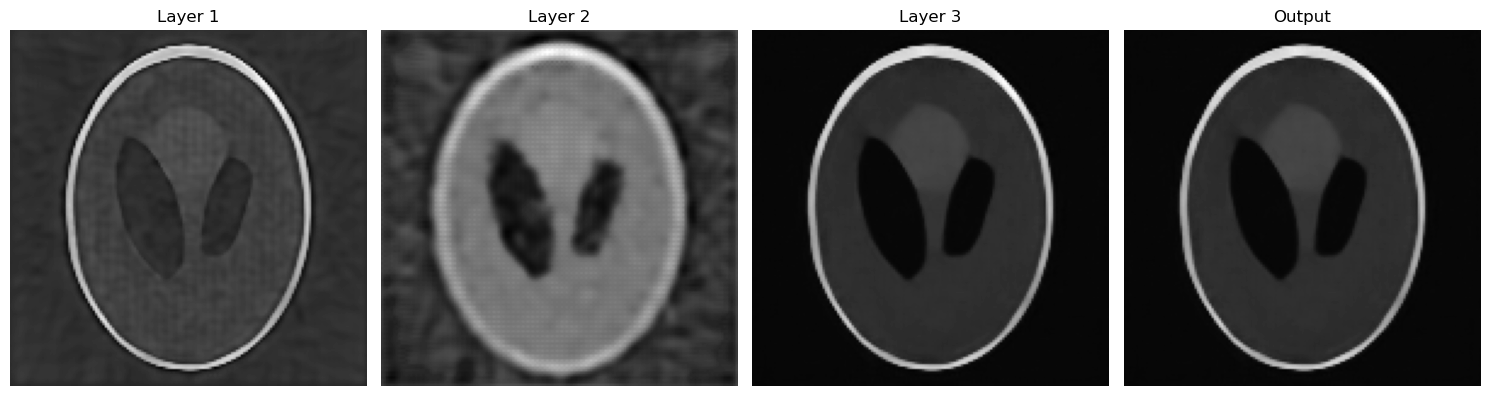

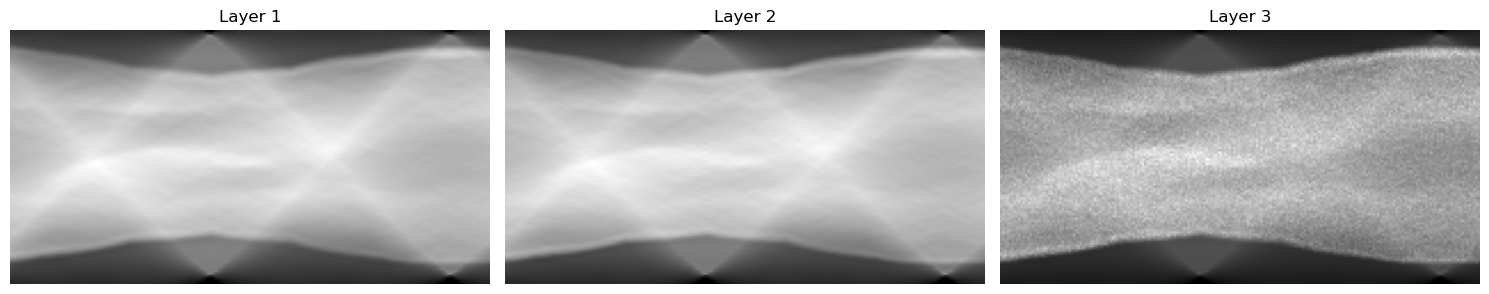

In [23]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False
)
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True
)

In [24]:
CONFIG_NAME_2: str = "lpdUnetTransformer2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_2}/*_weights.pt"

TransformerUnet2D_metrics = process_model_diff_noise(
    device,
    model,
    WEIGHTS_PATH,
    (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    miniPET_geometry.proj,
)

Execution time: 0.0760 seconds
Execution time: 0.0759 seconds
Execution time: 0.0762 seconds
Execution time: 0.0777 seconds
Execution time: 0.0762 seconds
Execution time: 0.0766 seconds
Execution time: 0.0764 seconds
Execution time: 0.0764 seconds
Execution time: 0.0763 seconds
Execution time: 0.0759 seconds
Execution time: 0.0760 seconds
Execution time: 0.0763 seconds
Execution time: 0.0760 seconds
Execution time: 0.0760 seconds
Execution time: 0.0765 seconds
Execution time: 0.0770 seconds
Execution time: 0.0761 seconds
Execution time: 0.0760 seconds
Execution time: 0.0760 seconds
Execution time: 0.0777 seconds
Execution time: 0.0776 seconds
Execution time: 0.0764 seconds
Execution time: 0.0760 seconds
Execution time: 0.0763 seconds
Execution time: 0.0773 seconds
Execution time: 0.0762 seconds
Execution time: 0.0766 seconds
Execution time: 0.0761 seconds
Execution time: 0.0762 seconds
Execution time: 0.0765 seconds
Execution time: 0.0762 seconds
Execution time: 0.0765 seconds
Executio

_3D U-Net LPD_


In [25]:
CONFIG_NAME_3: str = "lpdUnet3D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_3}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):

    # Initialise the full model
    model = _models.get_LPD_Unet3D_model(
        device,
        projector=miniPET_geometry.proj,
        n_iter=NUM_LPD_ITERATIONS,
    )

    # Move the model to the device
    model = model.to(device)
    (
        Unet3D_logan,
        Unet3D_logan_slice,
        Unet3D_mouse,
        Unet3D_mouse_slice,
    ) = process_model(
        device, model, file_name, sinogram_slp, sinogram_mouse, SLICE_TO_PLOT
    )

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet3D_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.1536 seconds
Execution time: 0.1026 seconds
Execution time: 0.0962 seconds
Execution time: 0.1031 seconds
Execution time: 0.0962 seconds
Execution time: 0.1039 seconds
MSE=3.67e-03 +/- 3.96e-04	SSIM=0.95 +/- 4.53e-03	PSNR=24.38 +/- 4.88e-01


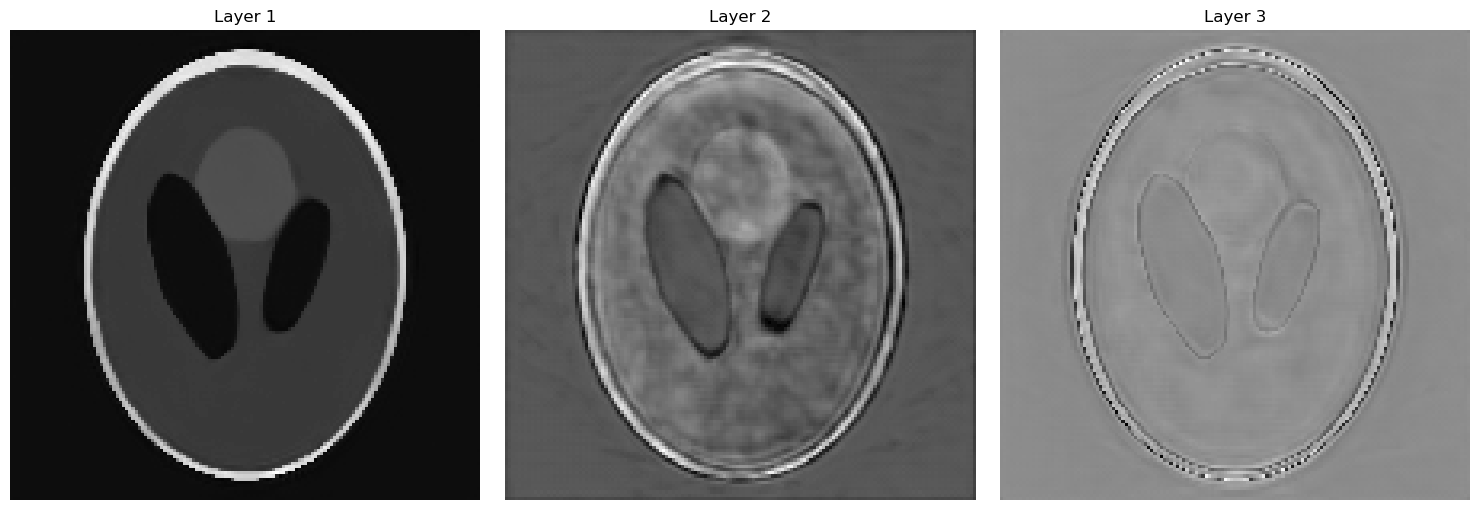

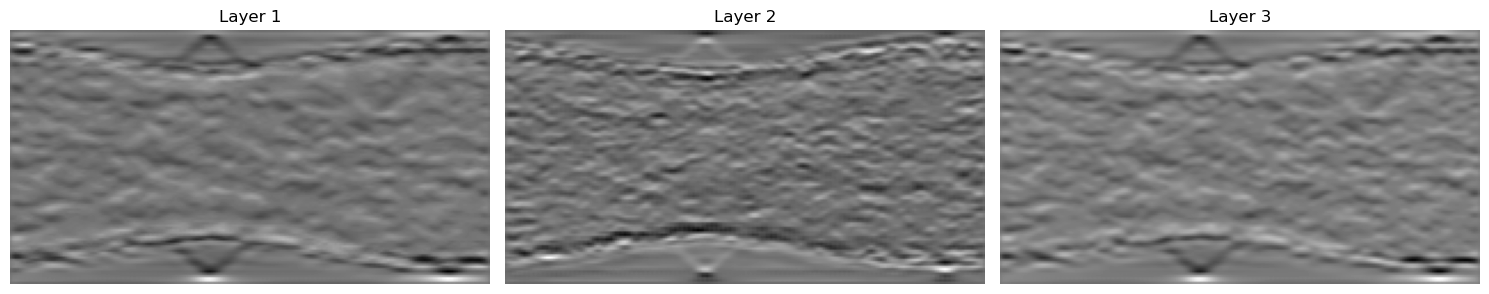

In [26]:
# Plot the outputs at each LPD iteration
plot_iterations_output_3d(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False
)
plot_iterations_output_3d(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True
)

In [27]:
CONFIG_NAME_3: str = "lpdUnet3D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_3}/*_weights.pt"

Unet3D_metrics = process_model_diff_noise(
    device,
    model,
    WEIGHTS_PATH,
    (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    miniPET_geometry.proj,
)

Execution time: 0.0970 seconds
Execution time: 0.0975 seconds
Execution time: 0.0965 seconds
Execution time: 0.0966 seconds
Execution time: 0.0964 seconds
Execution time: 0.0973 seconds
Execution time: 0.0970 seconds
Execution time: 0.0967 seconds
Execution time: 0.0967 seconds
Execution time: 0.0970 seconds
Execution time: 0.0966 seconds
Execution time: 0.0974 seconds
Execution time: 0.0971 seconds
Execution time: 0.0972 seconds
Execution time: 0.0971 seconds
Execution time: 0.0974 seconds
Execution time: 0.0979 seconds
Execution time: 0.0970 seconds
Execution time: 0.0972 seconds
Execution time: 0.1010 seconds
Execution time: 0.0974 seconds
Execution time: 0.0976 seconds
Execution time: 0.0971 seconds
Execution time: 0.0973 seconds
Execution time: 0.0970 seconds
Execution time: 0.0967 seconds
Execution time: 0.0972 seconds
Execution time: 0.0980 seconds
Execution time: 0.0971 seconds
Execution time: 0.0970 seconds
Execution time: 0.0973 seconds
Execution time: 0.0972 seconds
Executio

_Cross Image U-Net LPD_


In [28]:
CONFIG_NAME_4: str = "crossImageLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_4}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    # Initialise the full model
    model = _models.get_Cross_Image_LPD_Unet2D_model(
        device,
        projector=miniPET_geometry.proj,
        n_iter=NUM_LPD_ITERATIONS,
        patch_size=7,
        num_heads=2,
        embed_dim=64,
    )

    # Move the model to the device
    model = model.to(device)

    (
        CrossImageUnet2D_logan,
        CrossImageUnet2D_logan_slice,
        CrossImageUnet2D_mouse,
        CrossImageUnet2D_mouse_slice,
    ) = process_model(
        device, model, file_name, sinogram_slp, sinogram_mouse, SLICE_TO_PLOT
    )

    # Compute metrics
    metrics = compute_metrics(device, image_slp, CrossImageUnet2D_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.1183 seconds
Execution time: 0.1179 seconds
Execution time: 0.1170 seconds
Execution time: 0.1171 seconds
Execution time: 0.1166 seconds
Execution time: 0.1172 seconds
MSE=1.01e-02 +/- 2.86e-03	SSIM=0.88 +/- 4.09e-02	PSNR=20.11 +/- 1.14e+00


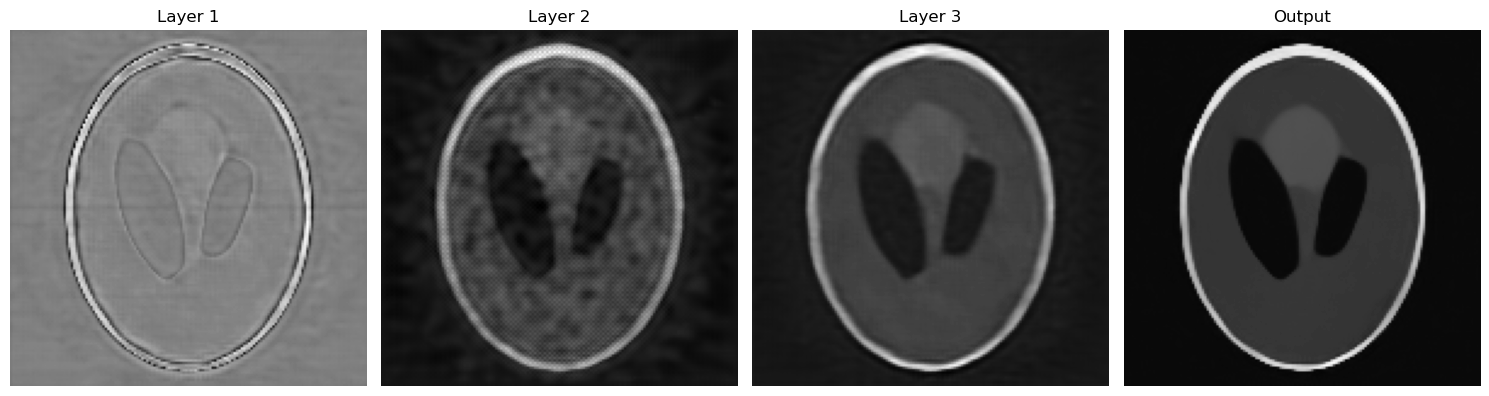

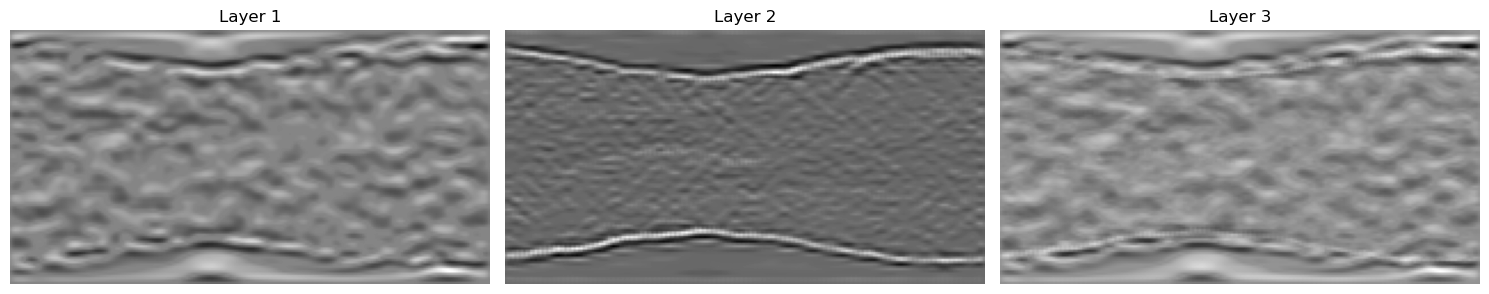

In [29]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False
)
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True
)

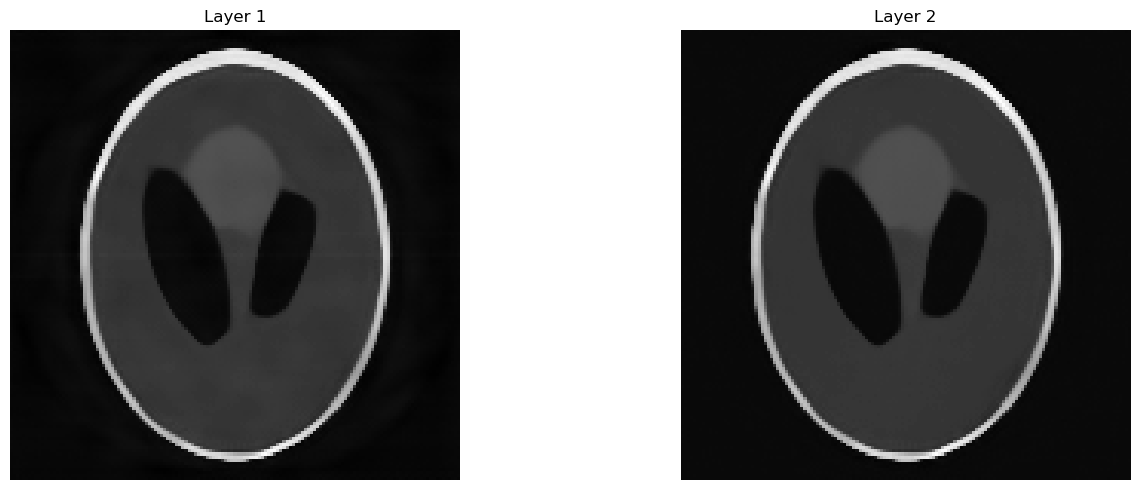

In [30]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False, cab=True
)

In [31]:
CONFIG_NAME_4: str = "crossImageLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_4}/*_weights.pt"

CrossImageUnet2D_metrics = process_model_diff_noise(
    device,
    model,
    WEIGHTS_PATH,
    (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    miniPET_geometry.proj,
)

Execution time: 0.1222 seconds
Execution time: 0.1177 seconds
Execution time: 0.1170 seconds
Execution time: 0.1172 seconds
Execution time: 0.1166 seconds
Execution time: 0.1176 seconds
Execution time: 0.1182 seconds
Execution time: 0.1169 seconds
Execution time: 0.1195 seconds
Execution time: 0.1184 seconds
Execution time: 0.1167 seconds
Execution time: 0.1175 seconds
Execution time: 0.1167 seconds
Execution time: 0.1166 seconds
Execution time: 0.1172 seconds
Execution time: 0.1173 seconds
Execution time: 0.1168 seconds
Execution time: 0.1172 seconds
Execution time: 0.1172 seconds
Execution time: 0.1171 seconds
Execution time: 0.1176 seconds
Execution time: 0.1170 seconds
Execution time: 0.1162 seconds
Execution time: 0.1165 seconds
Execution time: 0.1168 seconds
Execution time: 0.1167 seconds
Execution time: 0.1169 seconds
Execution time: 0.1168 seconds
Execution time: 0.1183 seconds
Execution time: 0.1172 seconds
Execution time: 0.1165 seconds
Execution time: 0.1168 seconds
Executio

_Cross Sinogram U-Net LPD_


In [32]:
CONFIG_NAME_5: str = "crossSinogramLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_5}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    # Initialise the full model
    model = _models.get_Cross_Sinogram_LPD_Unet2D_model(
        device,
        projector=miniPET_geometry.proj,
        n_iter=NUM_LPD_ITERATIONS,
        patch_size=21,
        num_heads=2,
        embed_dim=512,
        indices=indices,
    )

    # Move the model to the device
    model = model.to(device)

    (
        CrossSinogramUnet2D_logan,
        CrossSinogramUnet2D_logan_slice,
        CrossSinogramUnet2D_mouse,
        CrossSinogramUnet2D_mouse_slice,
    ) = process_model(
        device, model, file_name, sinogram_slp, sinogram_mouse, SLICE_TO_PLOT
    )

    # Compute metrics
    metrics = compute_metrics(device, image_slp, CrossSinogramUnet2D_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.1253 seconds
Execution time: 0.1305 seconds
Execution time: 0.1255 seconds
Execution time: 0.1305 seconds
Execution time: 0.1250 seconds
Execution time: 0.1300 seconds
MSE=9.04e-03 +/- 5.52e-04	SSIM=0.89 +/- 1.86e-02	PSNR=20.44 +/- 2.66e-01


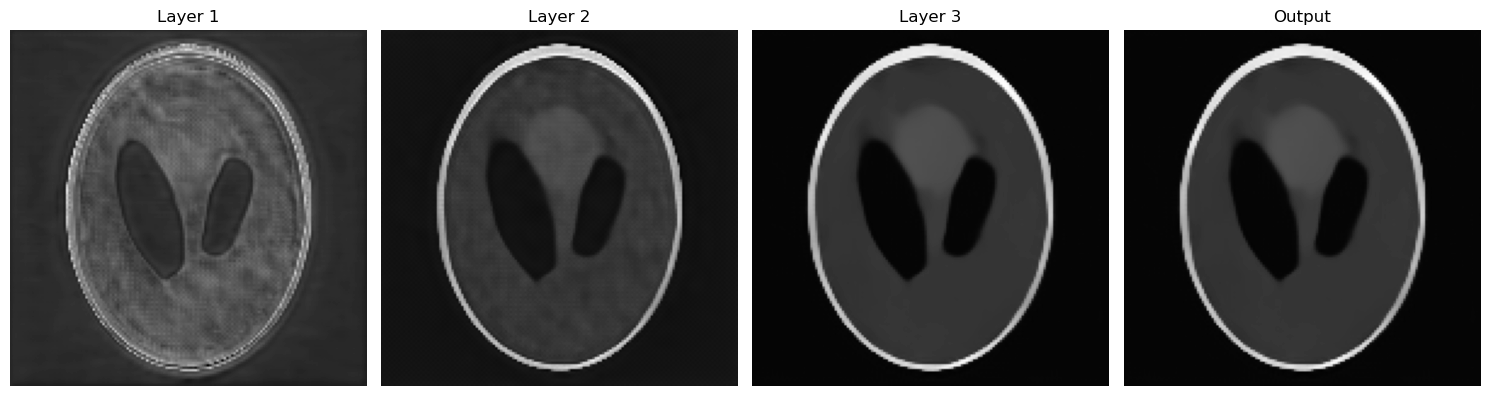

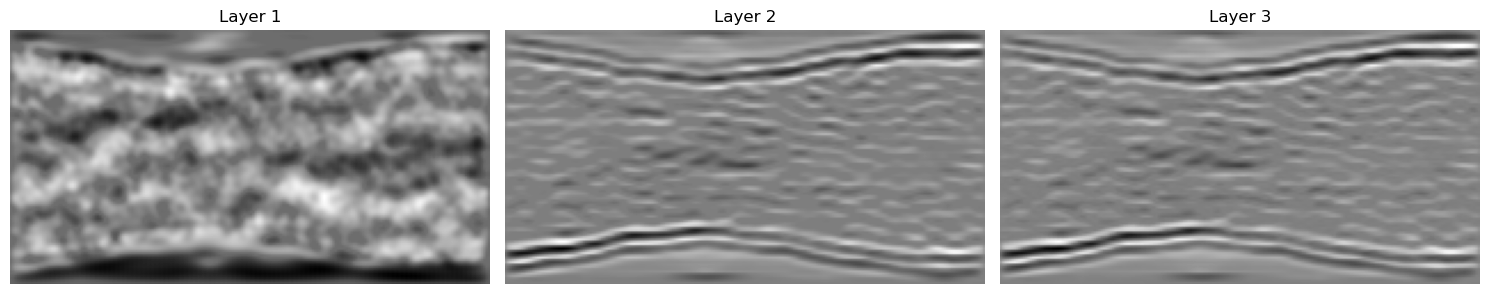

In [33]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False
)
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True
)

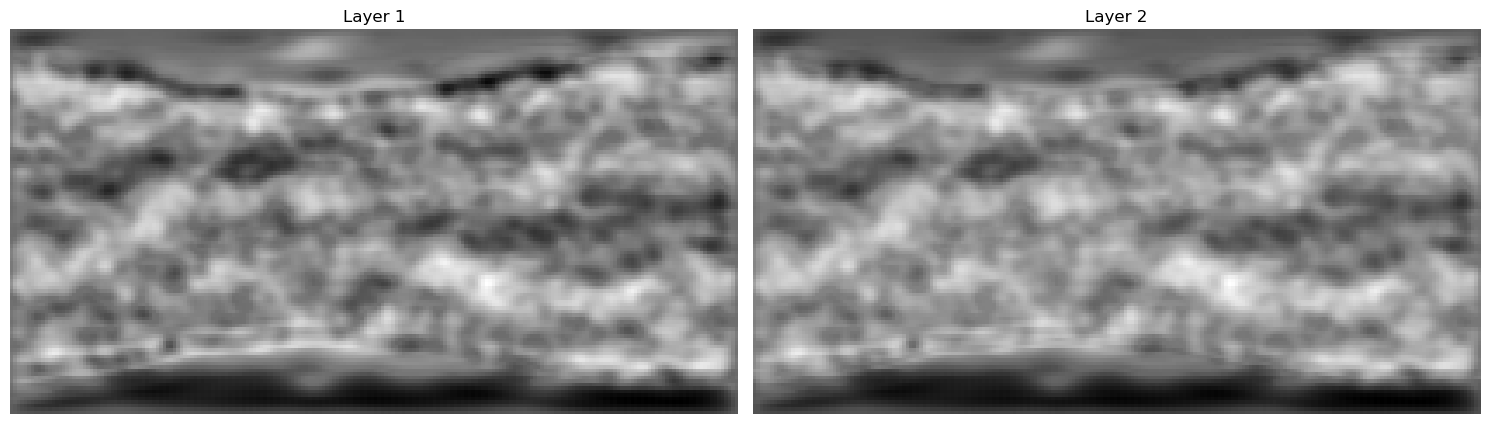

In [34]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True, cab=True
)

In [35]:
CONFIG_NAME_5: str = "crossSinogramLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_5}/*_weights.pt"

CrossSinogramUnet2D_metrics = process_model_diff_noise(
    device,
    model,
    WEIGHTS_PATH,
    (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    miniPET_geometry.proj,
)

Execution time: 0.1297 seconds
Execution time: 0.1260 seconds
Execution time: 0.1265 seconds
Execution time: 0.1266 seconds
Execution time: 0.1262 seconds
Execution time: 0.1263 seconds
Execution time: 0.1261 seconds
Execution time: 0.1289 seconds
Execution time: 0.1264 seconds
Execution time: 0.1256 seconds
Execution time: 0.1256 seconds
Execution time: 0.1270 seconds
Execution time: 0.1261 seconds
Execution time: 0.1260 seconds
Execution time: 0.1269 seconds
Execution time: 0.1257 seconds
Execution time: 0.1262 seconds
Execution time: 0.1261 seconds
Execution time: 0.1258 seconds
Execution time: 0.1259 seconds
Execution time: 0.1249 seconds
Execution time: 0.1297 seconds
Execution time: 0.1249 seconds
Execution time: 0.1255 seconds
Execution time: 0.1255 seconds
Execution time: 0.1262 seconds
Execution time: 0.1268 seconds
Execution time: 0.1252 seconds
Execution time: 0.1351 seconds
Execution time: 0.1257 seconds
Execution time: 0.1262 seconds
Execution time: 0.1257 seconds
Executio

_Cross Update U-Net LPD_


In [ ]:
CONFIG_NAME_6: str = "crossUpdateLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_6}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH)):
    # Initialise the full model
    model = _models.get_Cross_Update_LPD_Unet2D_model(
        device,
        projector=miniPET_geometry.proj,
        n_iter=NUM_LPD_ITERATIONS,
        patch_size=7,
        num_heads=2,
        embed_dim=64,
        embed_dim_dual=512,
        indices=indices,
    )

    # Move the model to the device
    model = model.to(device)

    (
        CrossUpdateUnet2D_logan,
        CrossUpdateUnet2D_logan_slice,
        CrossUpdateUnet2D_mouse,
        CrossUpdateUnet2D_mouse_slice,
    ) = process_model(
        device, model, file_name, sinogram_slp, sinogram_mouse, SLICE_TO_PLOT
    )
    # Compute metrics
    metrics = compute_metrics(device, image_slp, CrossUpdateUnet2D_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.1513 seconds
Execution time: 0.1378 seconds
Execution time: 0.1338 seconds
Execution time: 0.1350 seconds
Execution time: 0.1358 seconds
Execution time: 0.1365 seconds
MSE=8.87e-03 +/- 2.79e-04	SSIM=0.87 +/- 4.45e-02	PSNR=20.52 +/- 1.35e-01


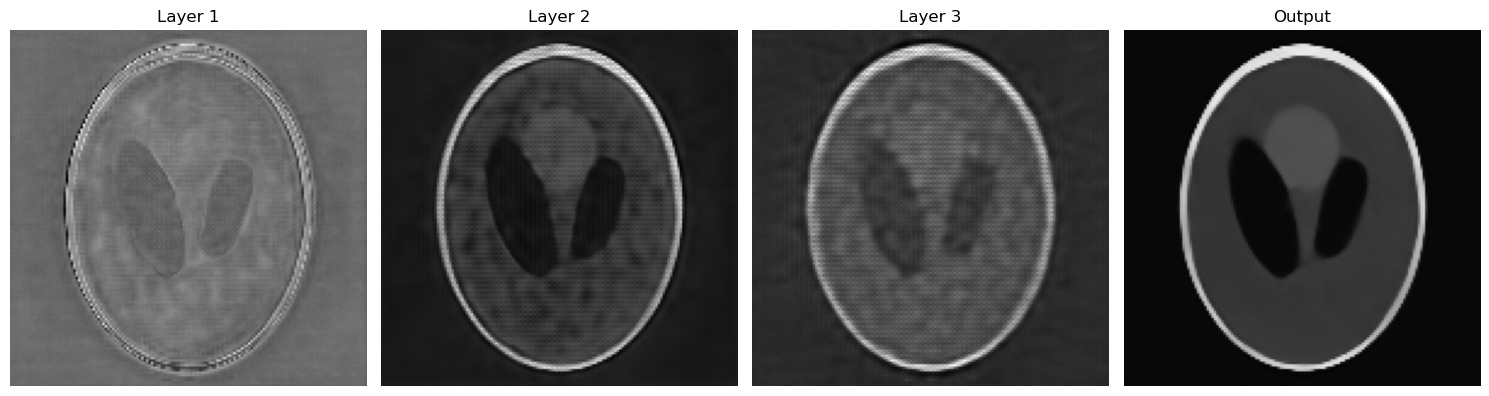

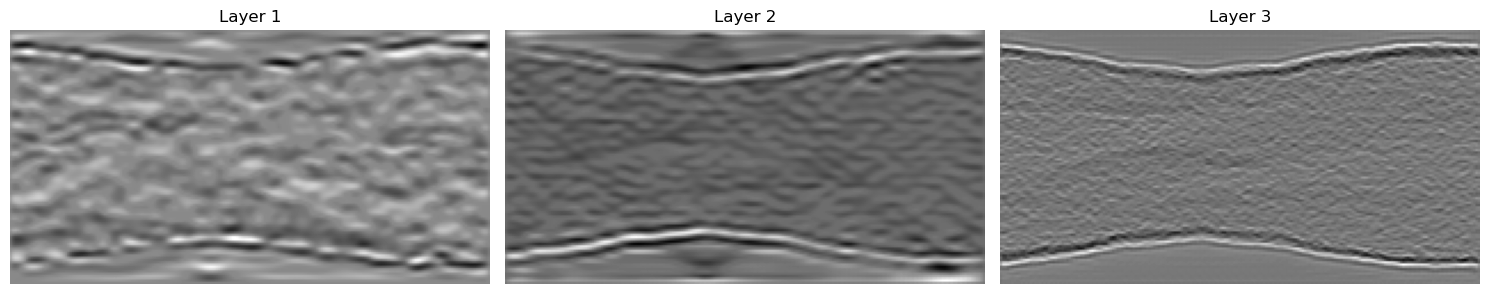

In [37]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False
)
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True
)

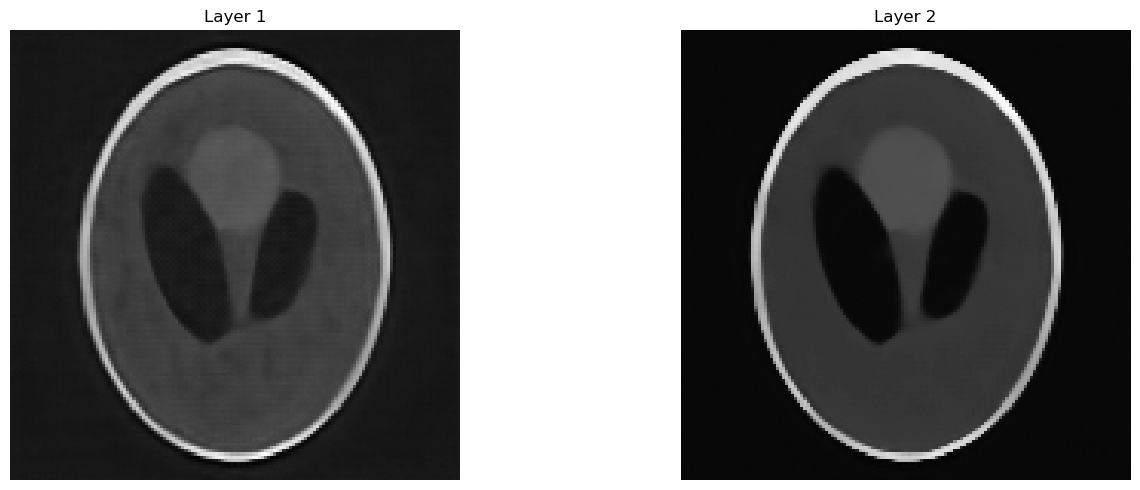

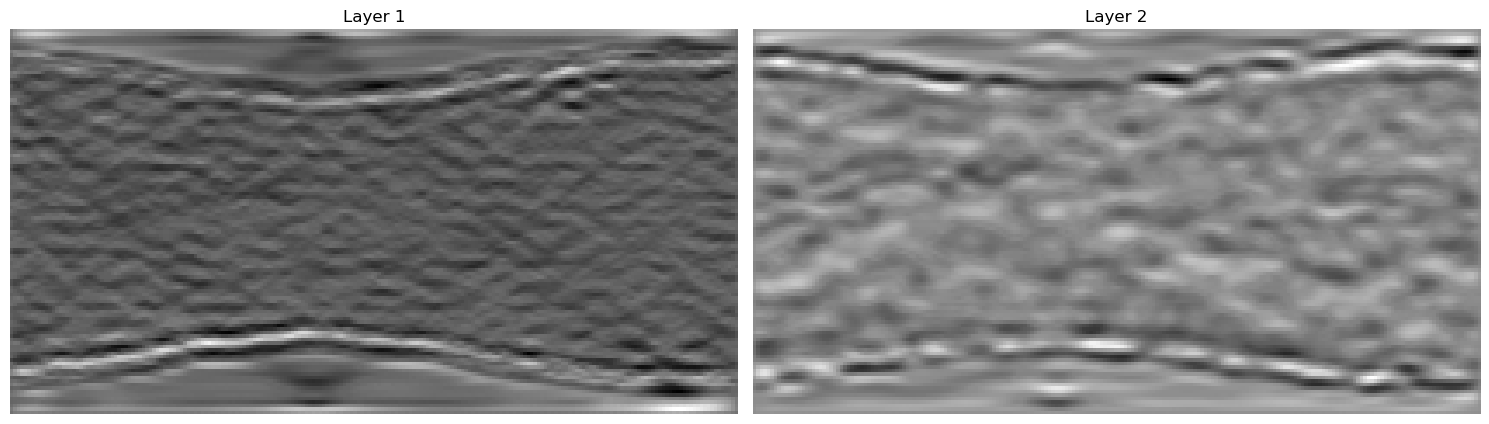

In [38]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False, cab=True
)

plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True, cab=True
)

In [39]:
CONFIG_NAME_6: str = "crossUpdateLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_6}/*_weights.pt"

CrossUpdateUnet2D_metrics = process_model_diff_noise(
    device,
    model,
    WEIGHTS_PATH,
    (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    miniPET_geometry.proj,
)

Execution time: 0.1467 seconds
Execution time: 0.1360 seconds
Execution time: 0.1512 seconds
Execution time: 0.1655 seconds
Execution time: 0.1356 seconds
Execution time: 0.1348 seconds
Execution time: 0.1349 seconds
Execution time: 0.1352 seconds
Execution time: 0.1350 seconds
Execution time: 0.1363 seconds
Execution time: 0.1354 seconds
Execution time: 0.1343 seconds
Execution time: 0.1351 seconds
Execution time: 0.1372 seconds
Execution time: 0.1344 seconds
Execution time: 0.1345 seconds
Execution time: 0.1344 seconds
Execution time: 0.1345 seconds
Execution time: 0.1354 seconds
Execution time: 0.1351 seconds
Execution time: 0.1378 seconds
Execution time: 0.1342 seconds
Execution time: 0.1346 seconds
Execution time: 0.1417 seconds
Execution time: 0.1344 seconds
Execution time: 0.1347 seconds
Execution time: 0.1375 seconds
Execution time: 0.1346 seconds
Execution time: 0.1355 seconds
Execution time: 0.1421 seconds
Execution time: 0.1346 seconds
Execution time: 0.1344 seconds
Executio

_Cross Concat U-Net LPD_


In [40]:
CONFIG_NAME_7: str = "crossConcatLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_7}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    # Initialise the full model
    model = _models.get_Cross_Concat_LPD_Unet2D_model(
        device,
        projector=miniPET_geometry.proj,
        n_iter=NUM_LPD_ITERATIONS,
        patch_size=7,
        num_heads=2,
        embed_dim=64,
        embed_dim_dual=384,
        indices=indices,
    )

    # Move the model to the device
    model = model.to(device)

    (
        CrossConcatUnet2D_logan,
        CrossConcatUnet2D_logan_slice,
        CrossConcatUnet2D_mouse,
        CrossConcatUnet2D_mouse_slice,
    ) = process_model(
        device, model, file_name, sinogram_slp, sinogram_mouse, SLICE_TO_PLOT
    )
    # Compute metrics
    metrics = compute_metrics(device, image_slp, CrossConcatUnet2D_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"MSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.1819 seconds
Execution time: 0.1997 seconds
Execution time: 0.1786 seconds
Execution time: 0.1841 seconds
Execution time: 0.1818 seconds
Execution time: 0.1842 seconds
MSE=9.07e-03 +/- 4.25e-04	SSIM=0.90 +/- 7.42e-03	PSNR=20.43 +/- 2.06e-01


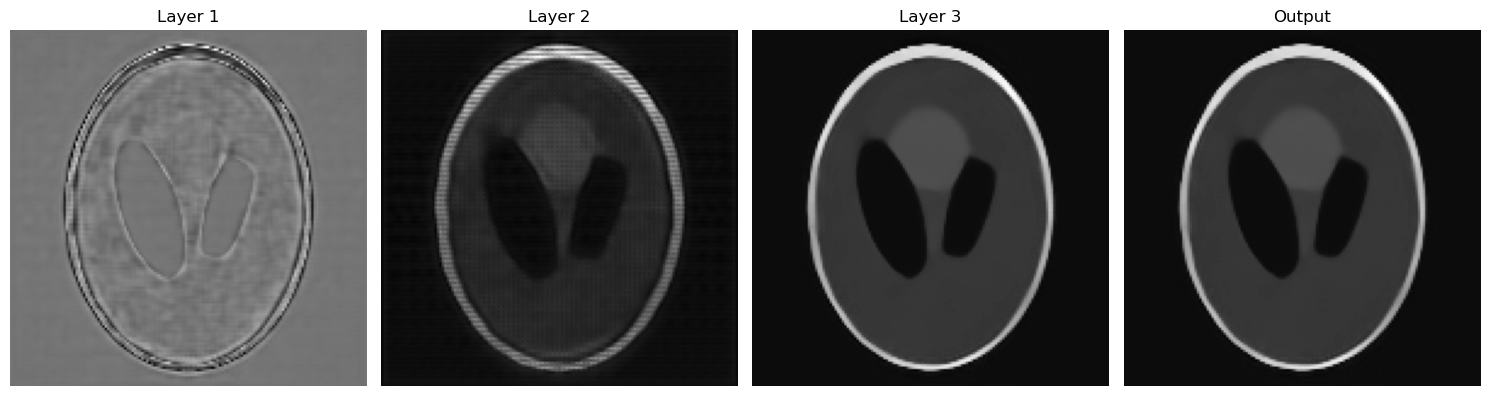

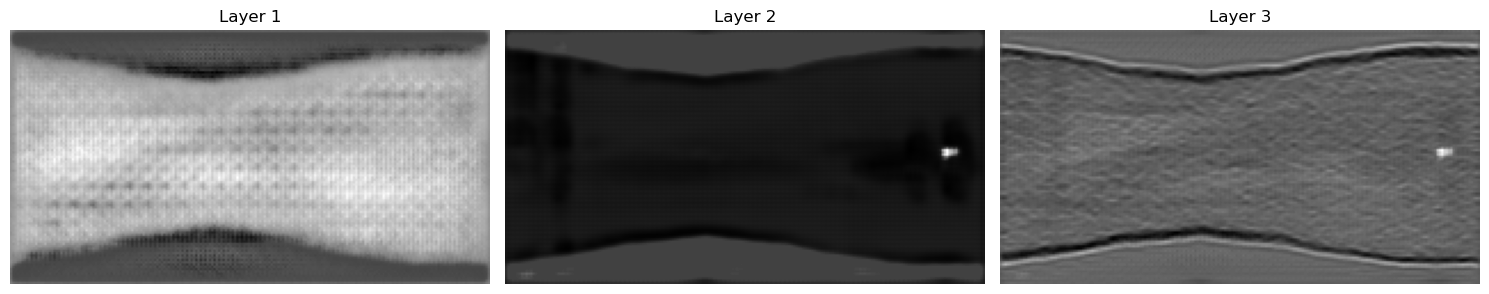

In [41]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False
)
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True
)

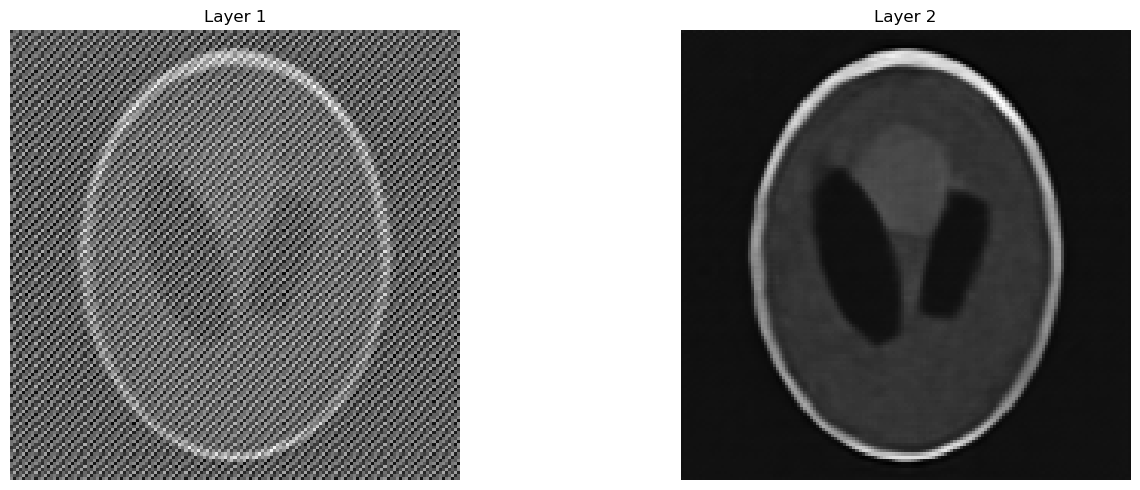

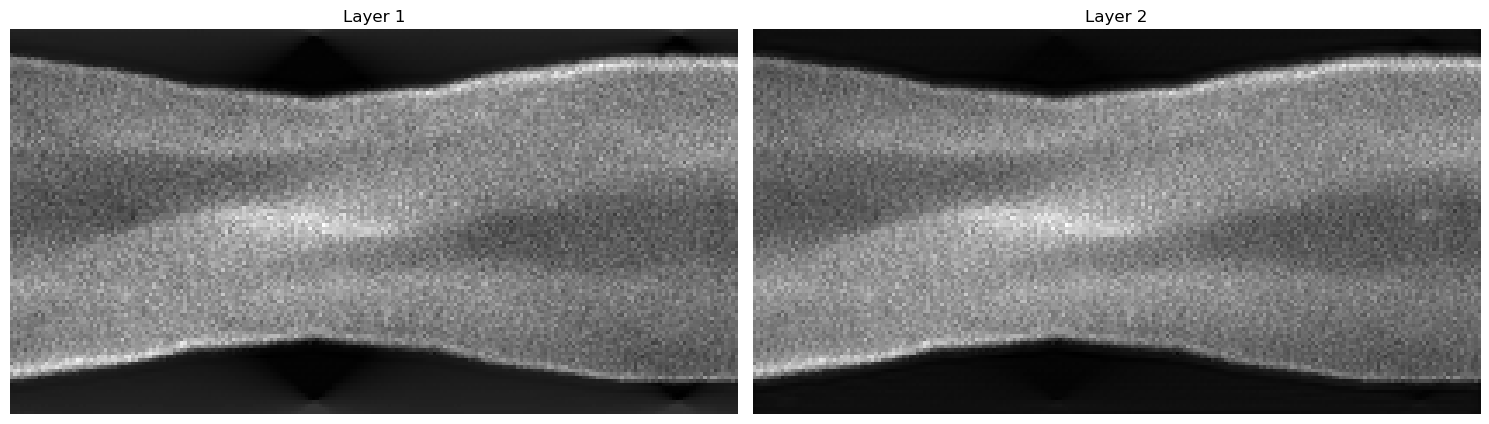

In [42]:
# Plot the outputs at each LPD iteration
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=False, cab=True
)
plot_iterations_output(
    device, model, sinogram_slp.unsqueeze(0), SLICE_TO_PLOT, dual=True, cab=True
)

In [43]:
CONFIG_NAME_7: str = "crossConcatLpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_7}/*_weights.pt"

CrossConcatUnet2D_metrics = process_model_diff_noise(
    device,
    model,
    WEIGHTS_PATH,
    (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    miniPET_geometry.proj,
)

Execution time: 0.1827 seconds
Execution time: 0.1867 seconds
Execution time: 0.1800 seconds
Execution time: 0.1800 seconds
Execution time: 0.1811 seconds
Execution time: 0.1839 seconds
Execution time: 0.1797 seconds
Execution time: 0.1798 seconds
Execution time: 0.1813 seconds
Execution time: 0.1820 seconds
Execution time: 0.1811 seconds
Execution time: 0.1801 seconds
Execution time: 0.1797 seconds
Execution time: 0.1841 seconds
Execution time: 0.1857 seconds
Execution time: 0.1814 seconds
Execution time: 0.1799 seconds
Execution time: 0.1814 seconds
Execution time: 0.1802 seconds
Execution time: 0.1813 seconds
Execution time: 0.1819 seconds
Execution time: 0.1823 seconds
Execution time: 0.1812 seconds
Execution time: 0.1834 seconds
Execution time: 0.1803 seconds
Execution time: 0.1830 seconds
Execution time: 0.1812 seconds
Execution time: 0.1812 seconds
Execution time: 0.1802 seconds
Execution time: 0.1826 seconds
Execution time: 0.1816 seconds
Execution time: 0.1807 seconds
Executio

### Different Noise Levels

Tests were conducted to evaluate model performance in the presence of different noise levels in the input sinogram. The noise levels applied to the input sinogram, generated from the Sheep-Logan phantom, ranged from 0.5 to 9.5.


In [44]:
from utils.plots import plot_metrics

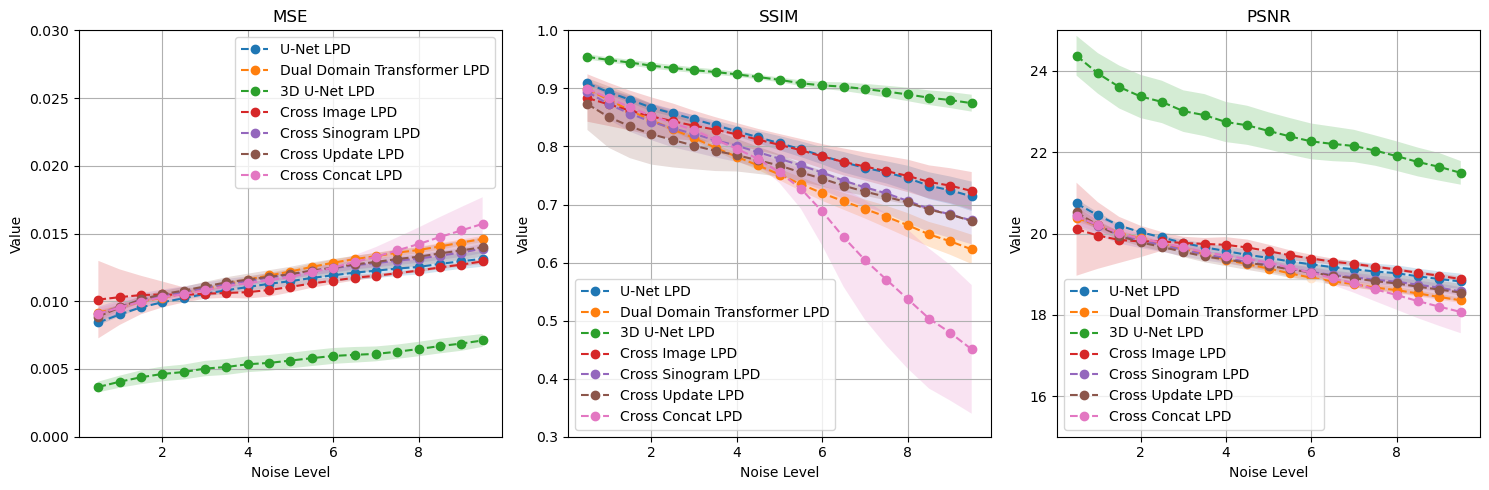

In [45]:
list_metrics = [
    (Unet2D_metrics, "U-Net LPD"),
    (TransformerUnet2D_metrics, "Dual Domain Transformer LPD"),
    (Unet3D_metrics, "3D U-Net LPD"),
    (CrossImageUnet2D_metrics, "Cross Image LPD"),
    (CrossSinogramUnet2D_metrics, "Cross Sinogram LPD"),
    (CrossUpdateUnet2D_metrics, "Cross Update LPD"),
    (CrossConcatUnet2D_metrics, "Cross Concat LPD"),
]
plot_metrics(list_metrics)

### Comparison


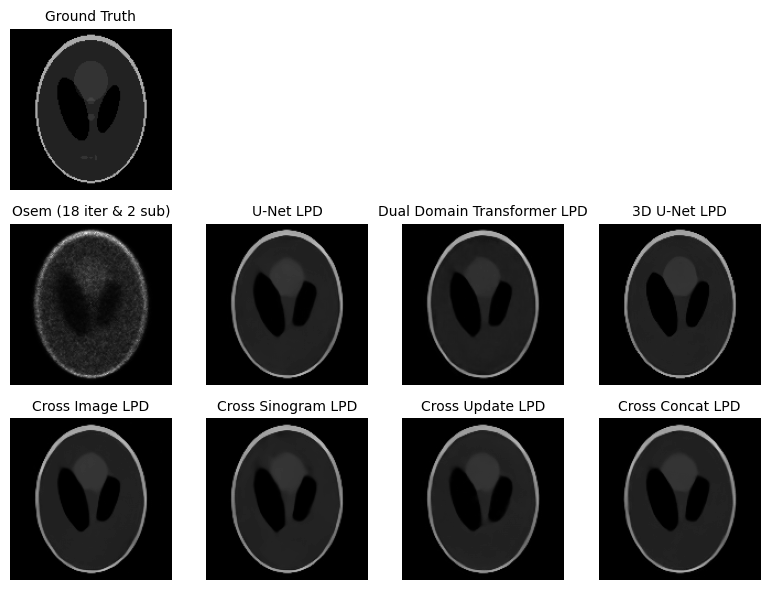

In [46]:
blank_image = torch.ones_like(slp_slice) * 2

list_imgs = [
    (slp_slice.cpu().numpy(), "Ground Truth"),
    (blank_image.cpu().numpy(), ""),
    (blank_image.cpu().numpy(), ""),
    (blank_image.cpu().numpy(), ""),
    (Osem_logan_slice.cpu().numpy(), "Osem (18 iter & 2 sub)"),
    (Unet2D_logan_slice.cpu().numpy(), "U-Net LPD"),
    (TransformerUnet2D_logan_slice.cpu().numpy(), "Dual Domain Transformer LPD"),
    (Unet3D_logan_slice.cpu().numpy(), "3D U-Net LPD"),
    (CrossImageUnet2D_logan_slice.cpu().numpy(), "Cross Image LPD"),
    (CrossSinogramUnet2D_logan_slice.cpu().numpy(), "Cross Sinogram LPD"),
    (CrossUpdateUnet2D_logan_slice.cpu().numpy(), "Cross Update LPD"),
    (CrossConcatUnet2D_logan_slice.cpu().numpy(), "Cross Concat LPD"),
]

plot_images(list_imgs, n_col=4)

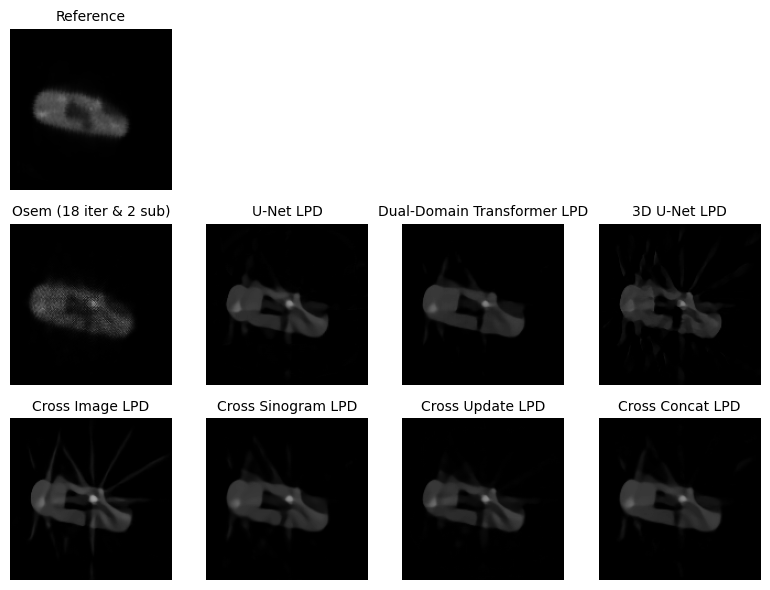

In [47]:
# Default sagittal slice
list_imgs = [
    (mouse_slice.cpu().numpy(), "Reference"),
    (blank_image.cpu().numpy(), ""),
    (blank_image.cpu().numpy(), ""),
    (blank_image.cpu().numpy(), ""),
    (Osem_mouse_slice.cpu().numpy(), "Osem (18 iter & 2 sub)"),
    (Unet2D_mouse_slice.cpu().numpy(), "U-Net LPD"),
    (TransformerUnet2D_mouse_slice.cpu().numpy(), "Dual-Domain Transformer LPD"),
    (Unet3D_mouse_slice.cpu().numpy(), "3D U-Net LPD"),
    (CrossImageUnet2D_mouse_slice.cpu().numpy(), "Cross Image LPD"),
    (CrossSinogramUnet2D_mouse_slice.cpu().numpy(), "Cross Sinogram LPD"),
    (CrossUpdateUnet2D_mouse_slice.cpu().numpy(), "Cross Update LPD"),
    (CrossConcatUnet2D_mouse_slice.cpu().numpy(), "Cross Concat LPD"),
]


plot_images(list_imgs, n_col=4)